## 📦 Phase 1: Setup & Import Required Libraries

In [1]:
# ============================================
# Phase 1: Setup & Library Imports
# ============================================

# Mount Google Drive if needed (Optional)
from google.colab import drive
drive.mount('/content/drive')

# Clone the dataset repository from GitHub
#!git clone https://github.com/ahmedhamada0/brain-tumor-detection-dataset.git /content/brain-tumor-dataset

# Import Python libraries
import os
import random
import shutil
from pathlib import Path
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("✅ Environment ready")


Mounted at /content/drive
✅ Environment ready


## 🧰 Phase 2: Dataset Preparation

In [2]:
# ============================================
# Phase 2: Dataset Preparation (Train/Val/Test)
# ============================================

from pathlib import Path
import shutil, random
from PIL import Image

# Use Google Drive as source
SRC = Path("/content/drive/MyDrive/DL_Project")  # <- your Drive folder
TARGET = Path("/content/brain-tumor-yolo")       # organized output
CLASSES = ["glioma", "meningioma", "pituitary", "notumor"]

# (Optional) Clean old TARGET to avoid duplicates across re-runs
if TARGET.exists():
    shutil.rmtree(TARGET)

# Create train, val, test folders
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        (TARGET / split / cls).mkdir(parents=True, exist_ok=True)

# Helper to check valid image files
def is_valid_image(p: Path):
    try:
        with Image.open(p) as im:
            im.verify()
        return True
    except Exception:
        return False

# Split ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1

# Split and copy files from Drive
for cls in CLASSES:
    src_dir = SRC / cls
    if not src_dir.exists():
        raise FileNotFoundError(f"Missing folder in Drive: {src_dir}")

    files = [p for p in src_dir.iterdir() if p.is_file() and is_valid_image(p)]
    random.shuffle(files)

    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_files = files[:n_train]
    val_files   = files[n_train:n_train + n_val]
    test_files  = files[n_train + n_val:]

    for p in train_files:
        shutil.copy2(p, TARGET / "train" / cls / p.name)
    for p in val_files:
        shutil.copy2(p, TARGET / "val" / cls / p.name)
    for p in test_files:
        shutil.copy2(p, TARGET / "test" / cls / p.name)

print("✅ Dataset organized into train / val / test")
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        count = len(list((TARGET / split / cls).glob("*")))
        print(f"{split}/{cls}: {count} images")

✅ Dataset organized into train / val / test
train/glioma: 1134 images
train/meningioma: 1151 images
train/pituitary: 1229 images
train/notumor: 1400 images
val/glioma: 324 images
val/meningioma: 329 images
val/pituitary: 351 images
val/notumor: 400 images
test/glioma: 163 images
test/meningioma: 165 images
test/pituitary: 177 images
test/notumor: 200 images


## 🧪 Phase 3: Data Visualization (Samples)

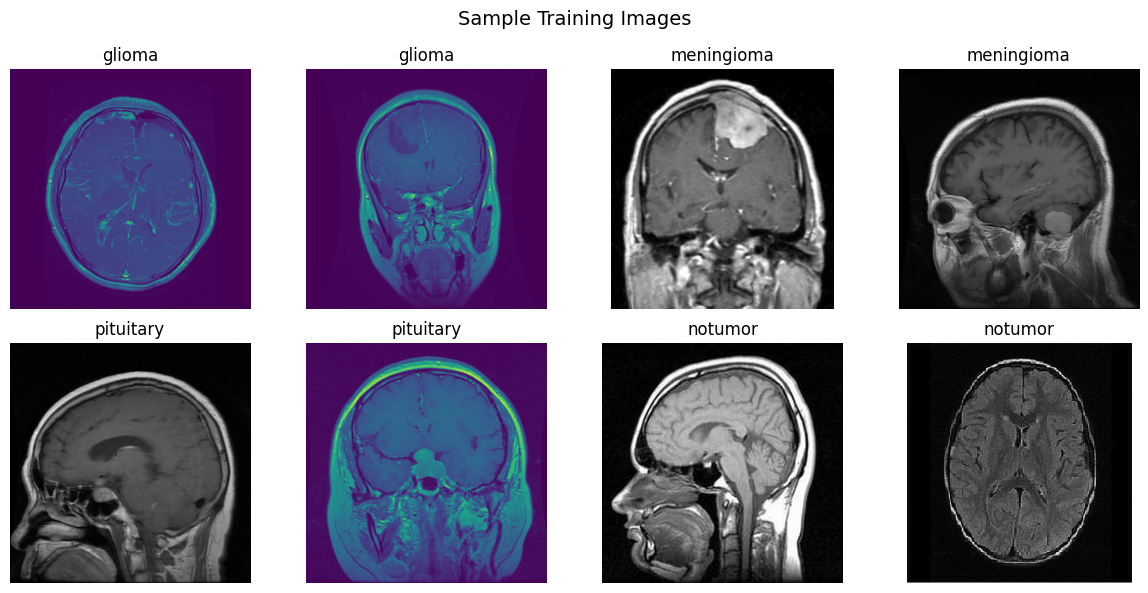

In [3]:
# ============================================
# Phase 3: Quick Visualization of Images
# ============================================

sample_paths = []
for cls in CLASSES:
    sample_paths += list((TARGET/"train"/cls).glob("*"))[:2]

plt.figure(figsize=(12,6))
for i, img_path in enumerate(sample_paths):
    img = Image.open(img_path)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(CLASSES[i//2])
plt.suptitle("Sample Training Images", fontsize=14)
plt.tight_layout()
plt.show()

## 🧠 Phase 4: Data Generators (Preprocessing)

In [4]:
# ============================================
# Phase 4: Data Generators & Preprocessing
# ============================================

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentation for training, only rescale for validation/test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TARGET/"train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_gen = val_test_datagen.flow_from_directory(
    TARGET/"val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_gen = val_test_datagen.flow_from_directory(
    TARGET/"test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("✅ Data generators ready")


Found 4914 images belonging to 4 classes.
Found 1404 images belonging to 4 classes.
Found 705 images belonging to 4 classes.
✅ Data generators ready


## 🏗 Phase 5: Build VGG19 Model

In [5]:
# ============================================
# Phase 5: Build VGG19 Transfer Learning Model
# ============================================

# Load base model without top classifier
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)   # 4 classes

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,156,740 (76.89 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

##
🚀 Phase 6: Callbacks and Training
python
Copy code


In [6]:
# ============================================
# Phase 6: Training Setup & Callbacks
# ============================================

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6),
    ModelCheckpoint("best_vgg19_model.h5", save_best_only=True)
]

EPOCHS = 15

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("✅ Training completed")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.2680 - loss: 1.5121

154/154 ━━━━━━━━━━━━━━━━━━━━ 117s 669ms/step - accuracy: 0.2682 - loss: 1.5116 - val_accuracy: 0.5264 - val_loss: 1.2034 - learning_rate: 1.0000e-04
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.4240 - loss: 1.2623

154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 525ms/step - accuracy: 0.4243 - loss: 1.2620 - val_accuracy: 0.5848 - val_loss: 1.0681 - learning_rate: 1.0000e-04
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.5453 - loss: 1.1158

154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 527ms/step - accuracy: 0.5454 - loss: 1.1156 - val_accuracy: 0.6531 - val_loss: 0.9658 - learning_rate: 1.0000e-04
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.6118 - loss: 1.0107

154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 527ms/step - accuracy: 0.6118 - loss: 1.0106 - val_accuracy: 0.6830 - val_loss: 0.8926 - learning_rate: 1.0000e-04
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.6478 - loss: 0.9396

154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 527ms/step - accuracy: 0.6478 - loss: 0.9395 - val_accuracy: 0.6603 - val_loss: 0.8548 - learning_rate: 1.0000e-04
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6523 - loss: 0.9018

154/154 ━━━━━━━━━━━━━━━━━━━━ 83s 540ms/step - accuracy: 0.6523 - loss: 0.9017 - val_accuracy: 0.6845 - val_loss: 0.8072 - learning_rate: 1.0000e-04
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.6716 - loss: 0.8455

154/154 ━━━━━━━━━━━━━━━━━━━━ 83s 539ms/step - accuracy: 0.6716 - loss: 0.8455 - val_accuracy: 0.6887 - val_loss: 0.7766 - learning_rate: 1.0000e-04
Epoch 8/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.6834 - loss: 0.8287

154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 527ms/step - accuracy: 0.6834 - loss: 0.8287 - val_accuracy: 0.7244 - val_loss: 0.7477 - learning_rate: 1.0000e-04
Epoch 9/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.6949 - loss: 0.8011

154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 533ms/step - accuracy: 0.6949 - loss: 0.8010 - val_accuracy: 0.7172 - val_loss: 0.7181 - learning_rate: 1.0000e-04
Epoch 10/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7144 - loss: 0.7684

154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 526ms/step - accuracy: 0.7144 - loss: 0.7684 - val_accuracy: 0.7130 - val_loss: 0.7085 - learning_rate: 1.0000e-04
Epoch 11/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.7231 - loss: 0.7391

154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 535ms/step - accuracy: 0.7230 - loss: 0.7391 - val_accuracy: 0.7436 - val_loss: 0.6759 - learning_rate: 1.0000e-04
Epoch 12/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7218 - loss: 0.7194

154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 523ms/step - accuracy: 0.7218 - loss: 0.7194 - val_accuracy: 0.7386 - val_loss: 0.6653 - learning_rate: 1.0000e-04
Epoch 13/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7331 - loss: 0.7053

154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 525ms/step - accuracy: 0.7330 - loss: 0.7053 - val_accuracy: 0.7557 - val_loss: 0.6468 - learning_rate: 1.0000e-04
Epoch 14/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7302 - loss: 0.7086

154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 528ms/step - accuracy: 0.7302 - loss: 0.7086 - val_accuracy: 0.7479 - val_loss: 0.6388 - learning_rate: 1.0000e-04
Epoch 15/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.7381 - loss: 0.6860

154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 534ms/step - accuracy: 0.7381 - loss: 0.6860 - val_accuracy: 0.7728 - val_loss: 0.6094 - learning_rate: 1.0000e-04
✅ Training completed


## 📊 Phase 7: Training Visualization (Accuracy & Loss Curves)

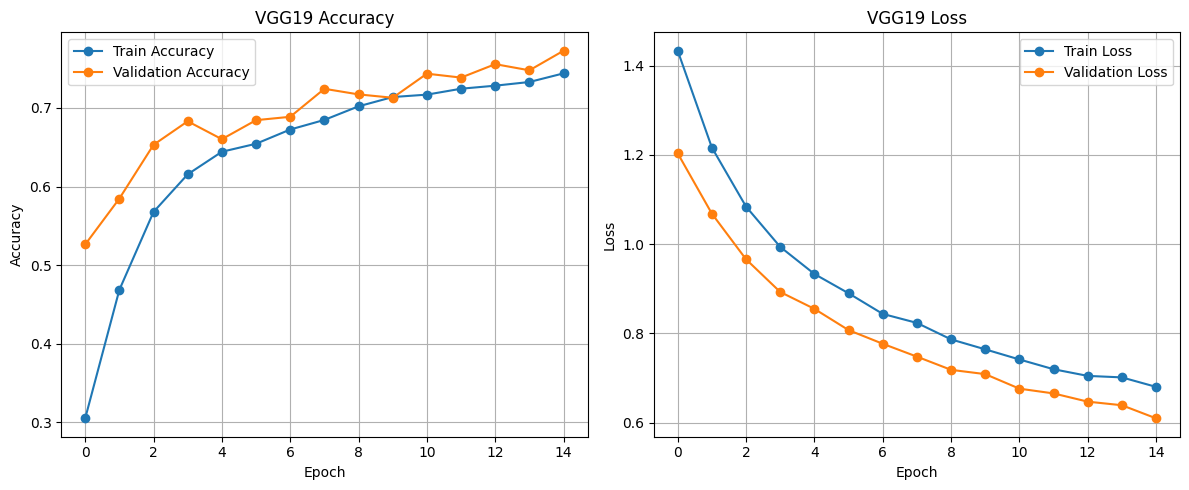

In [7]:
# ============================================
# Phase 7: Training Visualization
# ============================================

plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('VGG19 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('VGG19 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 🧪 Phase 8: Model Evaluation

In [8]:
# ============================================
# Phase 8: Evaluate Model on Test Data
# ============================================

test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.7385 - loss: 0.7091
✅ Test Accuracy: 79.57%
✅ Test Loss: 0.6034


## 🧾 Phase 9: Confusion Matrix & Classification Report

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step


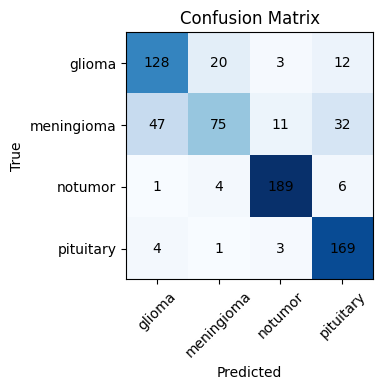

Classification Report:
              precision    recall  f1-score   support

      glioma     0.7111    0.7853    0.7464       163
  meningioma     0.7500    0.4545    0.5660       165
     notumor     0.9175    0.9450    0.9310       200
   pituitary     0.7717    0.9548    0.8535       177

    accuracy                         0.7957       705
   macro avg     0.7876    0.7849    0.7742       705
weighted avg     0.7940    0.7957    0.7835       705



In [9]:
# ============================================
# Phase 9: Confusion Matrix & Classification Report
# ============================================

# Predict on test data
y_pred_probs = model.predict(test_gen)              # shape (N, 4)
y_pred = np.argmax(y_pred_probs, axis=1)           # predicted class indices
y_true = test_gen.classes                           # true class indices
class_labels = list(test_gen.class_indices.keys())


# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.yticks(range(len(class_labels)), class_labels)
plt.xlabel('Predicted'); plt.ylabel('True')
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout(); plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))


## 💾 Phase 10: Save the Model & History

In [10]:
# ============================================
# Phase 10: Save Model and Training History
# ============================================

model.save("vgg19_brain_tumor_model.h5")

import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.to_csv("vgg19_training_history.csv", index=False)

print("✅ Model and training history saved successfully!")


✅ Model and training history saved successfully!
